# Generate annotations with Geolabel Maker

A tutorial provided by [Makina Corpus](https://makina-corpus.com/) &nbsp; [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makinacorpus/geolabel-maker/blob/master/notebooks/Generate%20a%20dataset%20with%20Geolabel%20%Maker.ipynb)

The notebook will guide you step by step on how to generate a dataset from scratch. In this tutorial, we will see how to create a ground truth from satellite imagery and vector geometries from data preparation to annotations. 

The necessary steps for the creation of this ground truth are:

**1. `generate_labels`: Generate labels from satellite imagery and vector geometries**

**2. `generate_mosaics` or `generate_tiles`: Generate subsets of images at a specific zoom level**

**3. `build_annotations`: Build the annotations from the satellite images and generated labels**

## Set Up

As always, we will load the required packages to generate a dataset. We will add ``geolabel_maker`` package to the path,
to make sure you can access its modules.  
As this notebook is available on google colaboratory, we need to load GDAL and other packages differently.

In [ ]:
import sys

RUN_ON_COLAB = False

# Check if its running from Colab
if "google.colab" in str(get_ipython()):
    RUN_ON_COLAB = True
    print("Running on Google Colab")
else:
    print("Running on Jupyter")

### For Jupyter users

The following code will load packages for Notebook users. Keep in mind that GDAL and other packages must be installed.

In [ ]:
if not RUN_ON_COLAB:
    sys.path.append("../")

### For Colab users

In [ ]:
if RUN_ON_COLAB:
    !git clone -b projinfo-dev https://github.com/makinacorpus/geolabel-maker
    !pip install -r /content/geolabel-maker/requirements.txt
    
    sys.path.append("/content/geolabel-maker")

In [ ]:
# Basic imports
import os
import sys
import matplotlib.pyplot as plt
from getpass import getpass
from pathlib import Path
import requests
import json

# Geolabel Maker
from geolabel_maker import Dataset
from geolabel_maker.rasters import Raster, RasterCollection
from geolabel_maker.vectors import Category, CategoryCollection
from geolabel_maker.annotations import COCO, ObjectDetection, Classification

### Speedups

Some users can experience issues related to ``shapely``. To fix it, simply use ``speedups.disable()``

In [6]:
# Disable speedups for windows users because they can experience errors
if os.name == "nt":
    from geolabel_maker import speedups
    
    speedups.disable()

## Explore the data

In this section, we will download and visualize the satellite images and vectors used to generate the annotations.

We will download rasters from Lyon, published as open data in the website [https://data.grandlyon.com](https://data.grandlyon.com):

- [1843_5173_08_CC46.tif](https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1843_5173_08_CC46.tif) from this [download page](https://data.grandlyon.com/jeux-de-donnees/orthophotographie-2018-metropole-lyon-format-tiff/donnees)
- [1844_5173_08_CC46.tif](https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1844_5173_08_CC46.tif) from this [download page](https://data.grandlyon.com/jeux-de-donnees/orthophotographie-2018-metropole-lyon-format-tiff/donnees)

We will also place them in a root directory ``data/images``, to faciliate the use of Geolabel Maker.

![images](medias/lyon_images.png)

The categories can also be downloaded from [Lyon's website](https://data.grandlyon.com).

- [buildings.json](https://download.data.grandlyon.com/wfs/grandlyon?SERVICE=WFS&VERSION=2.0.0&request=GetFeature&typename=cad_cadastre.cadbatiment&outputFormat=application/json;%20subtype=geojson&SRSNAME=EPSG:4171) from this [download page](https://data.grandlyon.com/jeux-de-donnees/batiments-metropole-lyon/telechargements)
- [vegetation.json](https://download.data.grandlyon.com/wfs/grandlyon?SERVICE=WFS&VERSION=2.0.0&request=GetFeature&typename=com_donnees_communales.comparcjardin_1_0_0&outputFormat=application/json;%20subtype=geojson&SRSNAME=EPSG:4171) from this [download page](https://data.grandlyon.com/jeux-de-donnees/parcs-jardins-metropole-lyon/telechargements)
- [bridges.json](https://download.data.grandlyon.com/wfs/grandlyon?SERVICE=WFS&VERSION=2.0.0&request=GetFeature&typename=fpc_fond_plan_communaut.fpcpont&outputFormat=application/json;%20subtype=geojson&SRSNAME=EPSG:4171) from this [download page](https://data.grandlyon.com/jeux-de-donnees/ponts-metropole-lyon/telechargements) (optional)

![categories](medias/lyon_categories.png)

First, let's create a function that will download all the data.

In [7]:
def download_image(url, out_file):
    """Download data from an url.
    
    Args:
        url (str): URL used to request data.
        out_file (str): Name of the output file.
    """
    Path(out_file).parent.mkdir(parents=True, exist_ok=True)
    with open(out_file, "wb") as handle:
        response = requests.get(url, stream=True)
        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)
    

def download_vector(url, out_file):
    """Download vector from an url.
    
    Args:
        url (str): URL used to request data.
        out_file (str): Name of the output file.
    """
    Path(out_file).parent.mkdir(parents=True, exist_ok=True)
    with open(out_file, "w") as handle:
        response = requests.get(url, stream=True)
        json.dump(response.json(), handle)

### Download images

Then, we will download the images and save them under ``data/images`` directory.

In [8]:
# Download 1843_5173_08_CC46 tile
url = "https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1843_5173_08_CC46.tif"
download_image(url, out_file="data/images/1843_5173_08_CC46.tif")

# Download 1844_5173_08_CC46 tile
url = "https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1844_5173_08_CC46.tif"
download_image(url, out_file="data/images/1844_5173_08_CC46.tif")

### Download vectors

We do the same for the vectors, except we save them under ``data/categiries`` directory.

In [9]:
# Download buildings
url = "https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/data/categories/buildings.json"
download_vector(url, out_file="data/categories/buildings.json")

# Download vegetation
url = "https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/data/categories/vegetation.json"
download_vector(url, out_file="data/categories/vegetation.json")

### Open the data

Once downloaded, we can open the data using ``Raster`` and ``Category`` classes from ``geolabel-maler``.
These classes heavily depends on ``rasterio`` and ``geopandas``. 

#### Open rasters

In [8]:
image = Raster.open("data/images/1843_5173_08_CC46.tif")
image

Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(4.837822228993922, 45.742008896443906, 4.850967763597565, 45.751212795629925), crs=EPSG:4326)

The ``Raster`` have a ``data`` argument, which corresponds to a ``rasterio.DatasetReader`` object.

In [9]:
image_data = image.data
image_data

<closed DatasetReader name='data/images/1843_5173_08_CC46.tif' mode='r'>

Notice that the ``rasterio.DatasetReader`` is close. You can easily open it using ``to_rasterio`` method:

In [10]:
image_data = image.rasterio()
image_data

<open DatasetReader name='data/images/1843_5173_08_CC46.tif' mode='r'>

To close the raster, use the ``close`` method from ``rasterio``:

In [11]:
image_data.close()
image_data

<closed DatasetReader name='data/images/1843_5173_08_CC46.tif' mode='r'>

Alternatively, you can load all rasters together with a ``RasterCollection``:

In [14]:
images = RasterCollection(image)
images

RasterCollection(
  (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(4.837822228993922, 45.742008896443906, 4.850967763597565, 45.751212795629925), crs=EPSG:4326)
)

Or you can load directly the rasters from their file name:

In [15]:
images = RasterCollection.open(
    "data/images/1843_5173_08_CC46.tif", 
    "data/images/1844_5173_08_CC46.tif"
)
images

Opening: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.61it/s]


RasterCollection(
  (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(4.837822228993922, 45.742008896443906, 4.850967763597565, 45.751212795629925), crs=EPSG:4326)
  (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(4.850669523495081, 45.741799315066885, 4.8638178112268315, 45.751004437030275), crs=EPSG:4326)
)

In [16]:
images = RasterCollection.from_dir("data/images", pattern="184[3||4]*")
images

Opening: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 58.83it/s]


RasterCollection(
  (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(4.837822228993922, 45.742008896443906, 4.850967763597565, 45.751212795629925), crs=EPSG:4326)
  (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(4.850669523495081, 45.741799315066885, 4.8638178112268315, 45.751004437030275), crs=EPSG:4326)
)

#### Open vectors

In ``geolabel-maker``, vectors are often called categories. The difference is that a category must have a name and color.

In [16]:
buildings = Category.open("data/categories/buildings.json", name="buildings", color="lightgrey")
buildings

Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)

In [17]:
vegetation = Category.open("data/categories/vegetation.json", name="vegetation", color="green")
vegetation

Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)

The ``Category`` have a ``data`` argument, which corresponds to a ``geopandas.GeoDataFrame`` object.

In [18]:
vegetation.data.head()

uid id_ariane                        nom    num numvoie  \
0  PAR-69387-57233     S8199         Berges du Rhône 7e  57233       1   
1  PAR-69383-03390     S8358   Esplanade Nelson Mandela   3390     128   
2  PAR-69383-03425     S8332        Jardin Abbé Boisard   3425     133   
3  PAR-69383-03358     S8355  Jardin Château sans souci   3358       3   
4  PAR-69388-08254     S8401       Jardin de la Laïcité   8254     123   

                                voie  codepost commune  code_insee reglement  \
0                  Berge du Rhône 7e     69007    Lyon       69387       Oui   
1                     Av Félix Faure     69003    Lyon       69383       Oui   
2                     Cours Gambetta     69003    Lyon       69383       Oui   
3  Rue des Cadets de la France Libre     69003    Lyon       69383       Oui   
4                 Rue Marius Berliet     69008    Lyon       69388       Oui   

   ...  label                            type_equip  eau toilettes chien  \
0  ...    Non  Aire de jeux-Fontaine-Espace ludique  Oui       Non   Oui   
1  ...    Non                 Aire de jeux-Fontaine  Oui       Oui   Oui   
2  ...    Non                                        Non       Non   Non   
3  ...    Non                          Aire de jeux  Oui       Non   Non   
4  ...    Non                          Aire de jeux  Non       Non   Non   

  esp_can photo gid ann_ouvert  \
0     Non     0  71       None   
1     Oui     0  74       None   
2     Non     0  75       None   
3     Non     0  85       None   
4     Non     0  98       None   

                                            geometry  
0  POLYGON ((1841971.660 5172496.720, 1841976.450...  
1  POLYGON ((1845012.240 5174011.930, 1845012.410...  
2  POLYGON ((1844498.200 5173951.000, 1844559.320...  
3  POLYGON ((1845215.820 5174281.220, 1845234.120...  
4  POLYGON ((1845280.270 5172675.550, 1845288.250...  

[5 rows x 27 columns]

Alternatively, you can load all categories together with a ``CategoryCollection``.

In [19]:
categories = CategoryCollection(buildings, vegetation)

If you create a collection from file names directly, you won't be able to set their color. Random ones will be generated:

In [20]:
categories = CategoryCollection.open(
    "data/categories/buildings.json", 
    "data/categories/vegetation.json"
)
categories

Opening: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.12it/s]


CategoryCollection(
  (0): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(206, 141, 126), crs=EPSG:3946)
  (1): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(17, 227, 242), crs=EPSG:3946)
)

In [21]:
categories = CategoryCollection.from_dir("data/categories", pattern="*.json")
categories

Opening: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]


CategoryCollection(
  (0): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(32, 160, 138), crs=EPSG:3946)
  (1): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(151, 243, 39), crs=EPSG:3946)
)

If you wish to change the colors, you have to do it manually:

In [22]:
categories = CategoryCollection(vegetation, buildings)
categories

CategoryCollection(
  (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
  (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)
)

In [23]:
categories[0].color = "green"
categories[1].color = "#92a9a2"

### Visualize the data

You can plot the data using ``plot`` methods. You can either plot the full data or only its bound, which is faster.

<AxesSubplot:title={'center':'CategoryCollection'}>

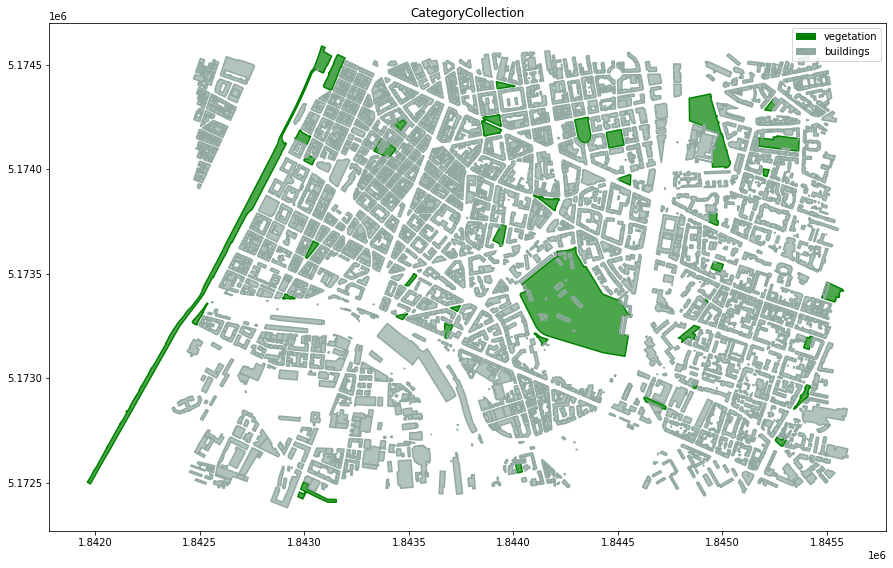

In [24]:
categories.plot(figsize=(15, 15))

## Create a dataset

Once you have your data, you can initialize a dataset. A ``Dataset`` is an object that contains your aerial or satellite images and a set of categories stored in the attributes ``images`` and ``categories`` respectively. This object will be used to generate labels (a.k.a masks from the categories), stored on disk and / or in its ``labels`` attribute. In addition this class is used to create tiles or mosaics from bigger images / labels.

### Load a dataset

You can create one directly using loaded rasters and categories collection. To keep track of our modification troughout the entire process, it is recommended to provide a ``filename`` to a ``Dataset``: it will keep track of all the variables used to generate the labels.

In [25]:
dataset = Dataset(images=images, categories=categories, filename="data/dataset.json")
dataset

Dataset(
  (root): 'data'
  (filename): 'data\dataset.json'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
    (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(146, 169, 162), crs=EPSG:3946)
  )
)

Notice that a ``dataset.json`` file should appear once the dataset is loaded. This file corresponds to the configuration of the dataset.
To control this behavior use the argument ``filename``:

```python
Dataset(images=images, categories=categories, filename="save/your/configuration/here/config.json")
```

Load it from a configuration:

In [8]:
Dataset.open("data/dataset.json")

Loading Categories: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


Dataset(
  (root): 'data'
  (filename): 'data\dataset.json'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
    (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(146, 169, 162), crs=EPSG:3946)
  )
)

You can also load directly your data from directories:

In [9]:
dataset = Dataset.from_dir(dir_images="data/images", dir_categories="data/categories")
dataset

Opening: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


Dataset(
  (root): '.'
  (filename): 'dataset.json'
  (dir_images): 'data\images'
  (dir_categories): 'data\categories'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(206, 141, 126), crs=EPSG:3946)
    (1): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(17, 227, 242), crs=EPSG:3946)
  )
)

Alternatively, you can load a ``Dataset`` from a root directory. If loaded from a ``root``, it will look for images and categories saved under ``images`` and ``categories`` directories.

In [7]:
dataset = Dataset.from_root(root="data")
dataset

Loading Categories: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.21it/s]


Dataset(
  (root): 'data'
  (filename): 'data\dataset.json'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
    (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(146, 169, 162), crs=EPSG:3946)
  )
)

If for some reasons the categories and images are in a different coordinate reference system, you can convert elements with ``to_crs``:

```python
dataset = dataset.to_crs(<crs>)
```

Also, if you are intersted in a smaller area you can crop the dataset with ``crop``:

```python
dataset = dataset.crop(<bbox>)
```

Finally, you can visualize the data with ``plot``, or ``plot_bounds``:

<AxesSubplot:title={'center':'Dataset'}>

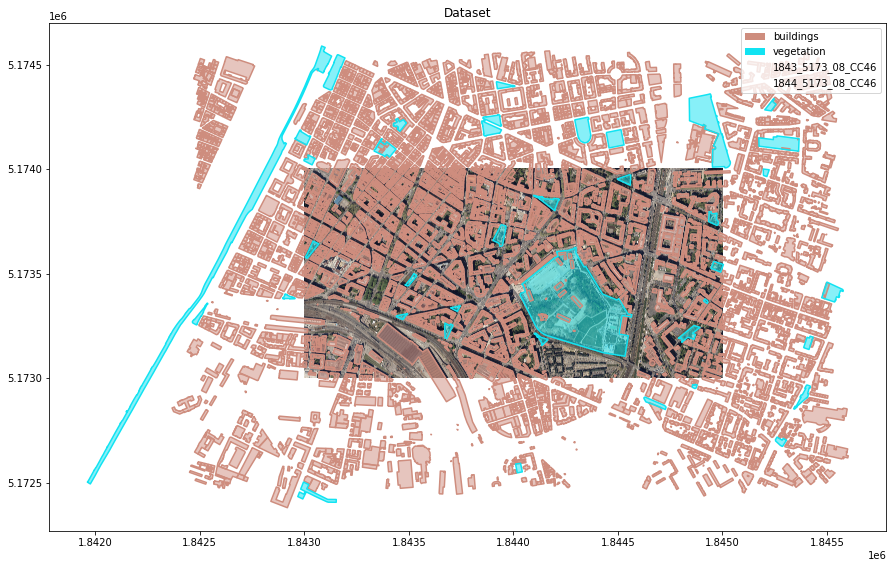

In [10]:
dataset.plot(figsize=(15, 15))

## Generate labels

Labels are rasterized categories. The color used are the categories' ones.  
Generate the labels with the method ``generate_labels``.

In [39]:
dataset.generate_labels()

Generating Labels: 100%|█████████████████████████████████████████████████████████████████| 2/2 [01:31<00:00, 45.97s/it]


'data\\labels'

The labels should look like:

![labels](medias/lyon_labels.png)

### Generate mosaics

Then, you can split the images and labels into smaller rasters. You can either create tiles or mosaics but note that the tiles generation is slow.   
To generate mosaics, use the ``generate_mosaics`` method.

In [49]:
dataset.generate_mosaics(zoom=18)

Generating Label Mosaics: 100%|██████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]


'data\\mosaics'

The mosaics should look like this (original resolution and zoom 18):

![mosaics](medias/lyon_mosaics.png)

### Generate tiles

The tiles generation requires ``gdal2tiles``.   
To generate tiles, use the ``generate_tiles`` method. As this method can takes hours (or days !), we will not run it in this notebook.

```python
dataset.generate_tiles(zoom="17")
```

### Configuration

As we said previously, the ``Dataset`` uses a configuration file to keep track of the process.  
Because we generated labels and mosaics (or tiles), the configuration was updated under the hood:

In [50]:
with open(dataset.filename, "r") as f:
    config = json.load(f)
    
config

{'images': [{'id': 0, 'filename': 'images\\1843_5173_08_CC46.tif'},
  {'id': 1, 'filename': 'images\\1844_5173_08_CC46.tif'}],
 'categories': [{'id': 0,
   'name': 'vegetation',
   'color': [0, 128, 0],
   'filename': 'categories\\vegetation.json'},
  {'id': 1,
   'name': 'buildings',
   'color': [146, 169, 162],
   'filename': 'categories\\buildings.json'}],
 'dir_labels': 'labels',
 'labels': [{'id': 0, 'filename': 'original\\1843_5173_08_CC46-label.tif'},
  {'id': 1, 'filename': 'original\\1844_5173_08_CC46-label.tif'}],
 'dir_mosaics': 'mosaics'}

Now, we have new fields that track labels and mosaics / tiles.

## Build annotations

To build the annotations, we must provide couples of images and labels. Any kind of rasters are accepted. For example, we can use the sub-images we generated (at zoom 17) to generate the annotations.

Multiple formats are available: 
- **COCO** format is used for semantic segmentation,
- **ObjectDetefction** format are used to localize (from a bounding box) objects in images,
- **Classification** for image classification.

### Generate COCO annotations

In [23]:
coco = COCO.build(
    dir_images = "data/mosaics/images/18",
    dir_labels = "data/mosaics/labels/18",
    categories = dataset.categories,
    pattern = "*.tif"
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 46.60it/s]


<AxesSubplot:title={'center':'image_id n°4'}>

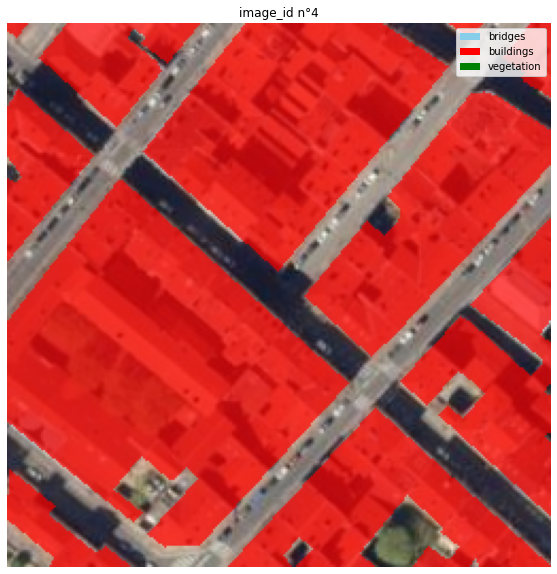

In [24]:
coco.plot(figsize=(10, 10), colors={"buildings": "red", "vegetation": "green"})

In [26]:
coco = COCO.make(
    dir_images = "data/mosaics/images/18",
    categories = dataset.categories,
    image_pattern = "*.tif"
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 72/72 [02:16<00:00,  1.89s/it]


<AxesSubplot:title={'center':'image_id n°25'}>

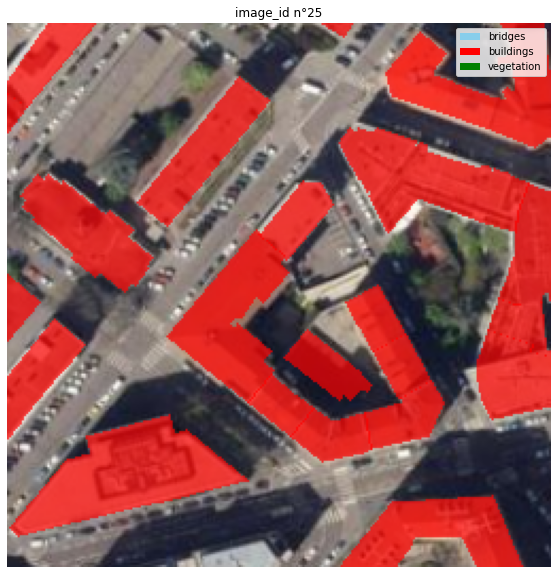

In [27]:
coco.plot(image_id=25, figsize=(10, 10), colors={"buildings": "red", "vegetation": "green"}, plot_bbox=False)

In [28]:
coco.save("coco.json")

### Generate object detection annotations

In [28]:
objects = ObjectDetection.build(
    dir_images = "data/mosaics/images/18",
    dir_labels = "data/mosaics/labels/18",
    categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 66.43it/s]


<AxesSubplot:title={'center':'image_id n°35'}>

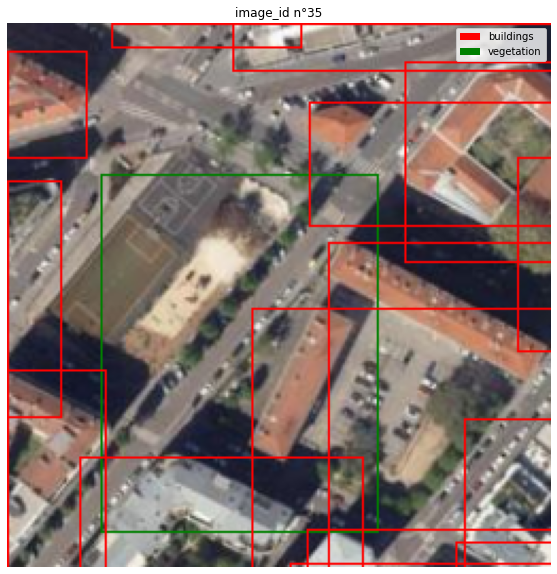

In [29]:
objects.plot(figsize=(10, 10), colors={"buildings": "red", "vegetation": "green"})

In [35]:
objects = ObjectDetection.make(
    dir_images = "data/mosaics/images/18",
    categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 72/72 [01:59<00:00,  1.65s/it]


<AxesSubplot:title={'center':'image_id n°34'}>

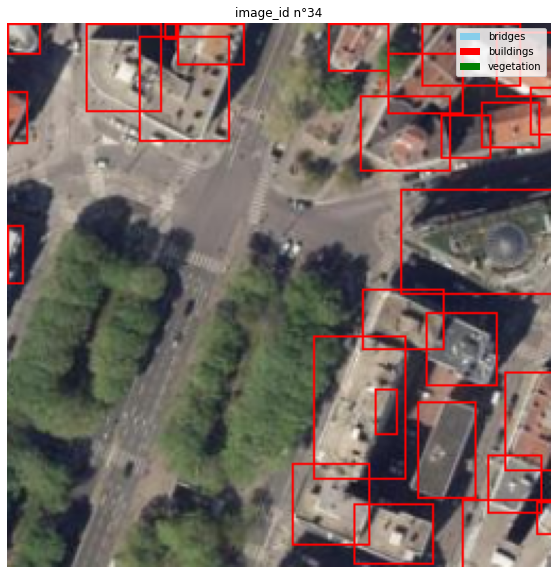

In [36]:
objects.plot(figsize=(10, 10), colors={"buildings": "red", "vegetation": "green"})

In [37]:
objects.save("objects.json")

### Generate Classification annotations

In [20]:
classif = Classification.build(
    dir_images = "data/mosaics/images/18",
    dir_labels = "data/mosaics/labels/18",
    categories = dataset.categories
)

Build Annotations: 100%|██████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 252.61it/s]


<AxesSubplot:title={'center':'image_id n°69'}>

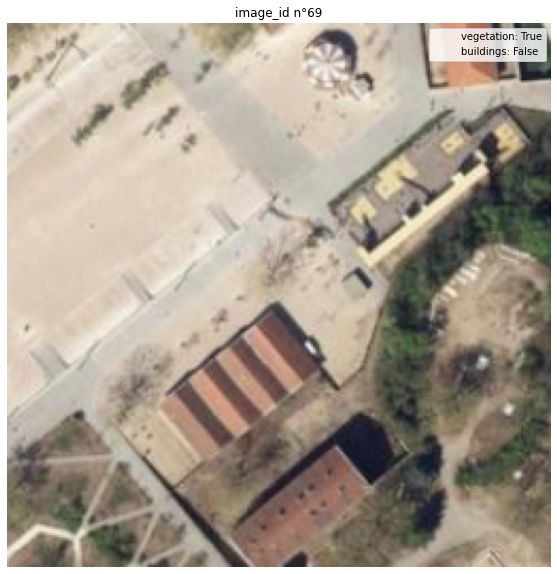

In [21]:
classif.plot(figsize=(10, 10))

In [40]:
classif = Classification.make(
    dir_images = "data/mosaics/images/18",
    categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 72/72 [01:57<00:00,  1.63s/it]


<AxesSubplot:title={'center':'image_id n°60'}>

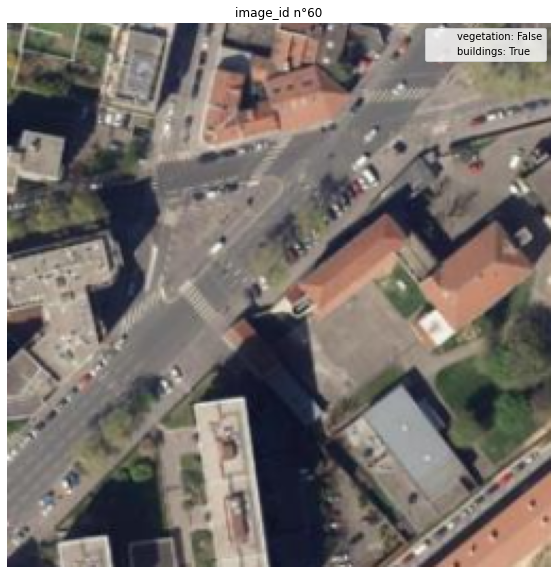

In [41]:
classif.plot(figsize=(10, 10))

In [23]:
classif.save("classification.txt")